In [113]:

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from functools import partial


# Helper Functions:

In [73]:

@jit
def count_neighbors(grid):
    """
    Count live neighbors for each cell using convolution.
    This is the JAX way - vectorized and fast!
    """
    # Create a kernel that counts the 8 neighbors
    kernel = jnp.array([[1, 1, 1],
                        [1, 0, 1],  # Center is 0 (don't count self)
                        [1, 1, 1]])
    
    # Pad the grid with zeros (dead cells at boundaries)
    padded = jnp.pad(grid, 1, mode='wrap')  # 'wrap' for toroidal topology
    
    # Count neighbors using convolution-like operation
    neighbors = jnp.zeros_like(grid)
    for i in range(3):
        for j in range(3):
            if i != 1 or j != 1:  # Skip center
                neighbors += padded[i:i+grid.shape[0], j:j+grid.shape[1]]
    
    return neighbors


@jit
def game_of_life_step(grid):
    """
    Apply Game of Life rules:
    1. Any live cell with 2-3 neighbors survives
    2. Any dead cell with exactly 3 neighbors becomes alive
    3. All other cells die or stay dead
    """
    neighbors = count_neighbors(grid)
    
    # Rule 1: Live cells with 2-3 neighbors survive
    survive = (grid == 1) & ((neighbors == 2) | (neighbors == 3))
    
    # Rule 2: Dead cells with 3 neighbors become alive
    born = (grid == 0) & (neighbors == 3)
    
    # Combine rules
    new_grid = (survive | born).astype(jnp.int32)
    
    return new_grid


def simulate_game_of_life(initial_grid, steps=100):
    """Run the Game of Life simulation for a number of steps"""
    grids = [initial_grid]
    grid = initial_grid
    
    for _ in range(steps):
        grid = game_of_life_step(grid)
        grids.append(grid)
    
    return grids


#### Stochastic GoL:

In [125]:

@partial(jit, static_argnums=(2,))
def stochastic_game_of_life_step(grid, key, temperature=0.1):
    """Flip-based stochastic GoL - THE GOOD ONE"""
    neighbors = count_neighbors(grid)
    survive = (grid == 1) & ((neighbors == 2) | (neighbors == 3))
    born = (grid == 0) & (neighbors == 3)
    deterministic_next = (survive | born).astype(jnp.float32)
    
    # Thermal fluctuations - probability depends on stability
    key, subkey = random.split(key)
    stability = jnp.exp(-neighbors / 2.0)
    flip_probability = temperature * stability
    
    thermal_flip = random.uniform(subkey, grid.shape) < flip_probability
    noisy_state = jnp.where(thermal_flip, 
                            1 - deterministic_next,
                            deterministic_next)
    
    return noisy_state.astype(jnp.int32), key


def simulate_stochastic_pattern(grid, key, steps=100, temperature=0.1):
    """
    Stochastic simulation - returns list of grids and final key
    
    Parameters:
    -----------
    grid : jnp.array
        Initial pattern
    key : jax.random.PRNGKey
        Initial random key
    steps : int
        Number of steps to simulate
    temperature : float
        Temperature parameter (0 = deterministic)
    
    Returns:
    --------
    grids : list of jnp.array
        All states including initial
    key : jax.random.PRNGKey
        Final random key
    
    Example:
    --------
    >>> from jax import random
    >>> grid = create_glider()
    >>> key = random.PRNGKey(42)
    >>> grids, key = simulate_stochastic_pattern(grid, key, steps=50, temperature=0.1)
    >>> print(f"Simulated {len(grids)} frames")
    """
    grids = [grid]
    current = grid
    
    for _ in range(steps):
        current, key = stochastic_game_of_life_step(current, key, temperature=temperature)
        grids.append(current)
    
    return grids, key

#### Initialize Grids:

In [97]:
# Create grids

def create_glider(grid_size):
    """Create a grid with a glider pattern"""
    grid = jnp.zeros((grid_size, grid_size), dtype=jnp.int32)
    
    # Glider pattern (top-left area)
    glider = jnp.array([[0, 1, 0],
                        [0, 0, 1],
                        [1, 1, 1]], dtype=jnp.int32)
    
    grid = grid.at[1:4, 1:4].set(glider)
    return grid


def create_random_grid(key, grid_size, density=0.3):
    """Create a random grid with given density of live cells"""
    return (random.uniform(key, (grid_size, grid_size)) < density).astype(jnp.int32)


def create_pattern_1_gosper_glider_gun(size=50):
    """
    Gosper Glider Gun - The most famous pattern!
    Discovered in 1970, this creates gliders indefinitely.
    Proves that patterns can grow without bound.
    """
    grid = jnp.zeros((size, size), dtype=jnp.int32)
    
    # Gosper Glider Gun pattern (centered)
    gun = [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ]
    
    gun_array = jnp.array(gun, dtype=jnp.int32)
    start_row = 5
    start_col = 5
    grid = grid.at[start_row:start_row+len(gun), start_col:start_col+len(gun[0])].set(gun_array)
    
    return grid, "Gosper Glider Gun", "Creates gliders indefinitely - the first discovered 'gun'"


In [169]:
def create_animation(grids, save_path='game_of_life.gif', interval=100, temperature=0.0):
    """Create an animated GIF of the Game of Life"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Initial frame
    im = ax.imshow(grids[0], cmap='Purples', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)
    
    # Create title with temperature
    if temperature == 0.0:
        title_text = 'Game of Life (Deterministic) - Step 0'
    else:
        title_text = f'Game of Life (T={temperature:.2f}) - Step 0'
    
    title = ax.set_title(title_text, fontsize=14, fontweight='bold')
    
    def update(frame):
        im.set_array(grids[frame])
        # Update title with temperature info
        if temperature == 0.0:
            title.set_text(f'Game of Life (Deterministic) - Step {frame}')
        else:
            title.set_text(f'Game of Life (T={temperature:.6f}) - Step {frame}')
        return [im, title]
    
    anim = FuncAnimation(fig, update, frames=len(grids), 
                        interval=interval, blit=True)
    
    try:
        anim.save(save_path, writer='pillow', fps=10)
        print(f"Animation saved to: {save_path}")
    except Exception as e:
        print(f"Could not save animation: {e}")
    finally:
        plt.close()

# Run Game of Life:

In [51]:
!ls

Conway_game_of_life_JAX.ipynb outputs


In [52]:
!mkdir outputs

mkdir: outputs: File exists


In [100]:
# options 
# 0.) glider
# 1.) random; seed (default: 42)
# 2.) gosper_glider_gun

initial_grid_option = 'gosper_glider_gun'

if initial_grid_option=='glider':
    grid = create_glider(size=50)[0]

elif initial_grid_option=='random':
    seed=42
    key = random.PRNGKey(seed)    
    grid = create_random_grid(key=key, grid_size=50, density=0.3)

elif initial_grid_option=='gosper_glider_gun':
    create_pattern_1_gosper_glider_gun(size=50)[0]

else:
    print('Pick an initial grid properly!')

In [107]:
grids = simulate_game_of_life(grid, steps=10000)

In [211]:
# T=0: deterministic GoL
# T=1E-5: not enough to overcome the minima reached with gosper glider gun. 
# T=1E-4: stops the converging patterns for gosper glider gun
# T=1E-3 stops the converging patterns for gosper glider gun
# T=1E-2 stops the converging patterns for gosper glider gun
# T=0.1: more stochastic
# T=0.5: a lot more stochasticity
# T=0.95: near max stochatic
# T=0.99 # close to fully noisy
# T=1.0 # fully noisy

grids = simulate_stochastic_pattern(grid, key, steps=1000, temperature=0.99)[0]

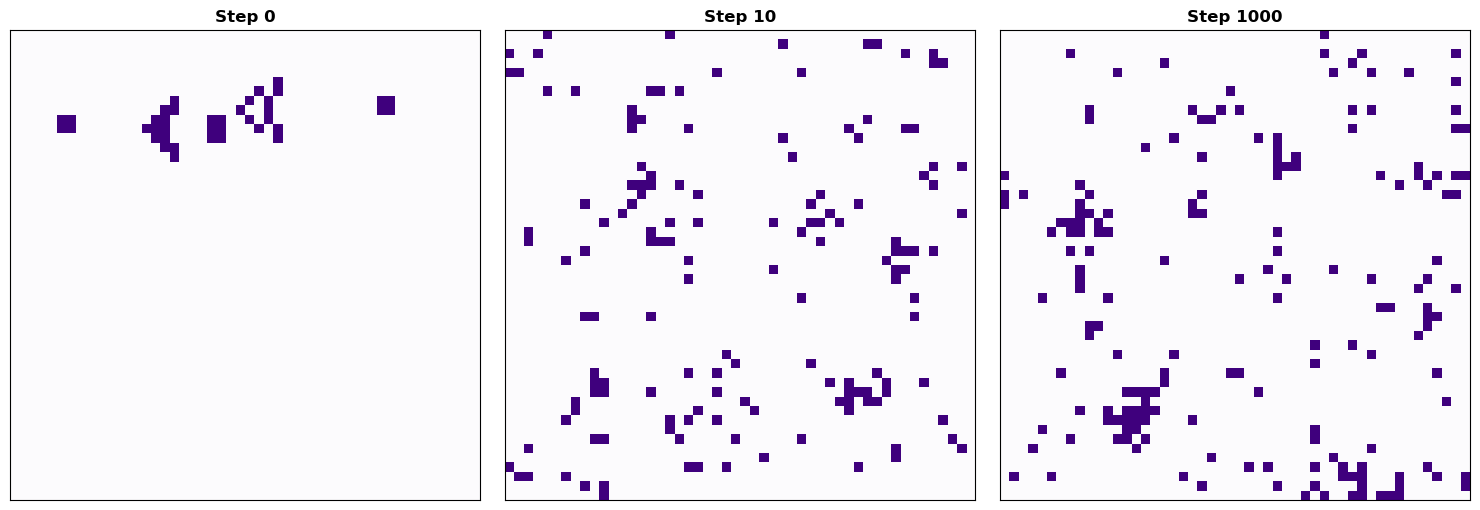

In [212]:
# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each grid
axes[0].imshow(grids[0], cmap='Purples', interpolation='nearest')
axes[0].set_title('Step 0', fontsize=12, fontweight='bold')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(grids[200], cmap='Purples', interpolation='nearest')
axes[1].set_title('Step 10', fontsize=12, fontweight='bold')
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(grids[-1], cmap='Purples', interpolation='nearest')
axes[2].set_title(f'Step {len(grids)-1}', fontsize=12, fontweight='bold')
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show()

In [213]:
create_animation(
    grids,
    save_path='./outputs/V20251112_gosper_glider_gun_temp0.99_steps1000.gif',
    interval=1000,
    temperature=0.99
)

Animation saved to: ./outputs/V20251112_gosper_glider_gun_temp0.99_steps1000.gif


## Count Number of Cells Per Timestep:

In [227]:
from tqdm import tqdm

In [262]:
def count_pop_per_timestep(grids):

    cnt_pop_time_steps = [jnp.sum(grid).item() for grid in grids]
    
    return cnt_pop_time_steps
key = random.PRNGKey(42)

In [246]:
# count cell populatinos per tiemstep for the different temps...

cnt_pop_dict = {f'{temp}': count_pop_per_timestep(simulate_stochastic_pattern(grid, key, steps=1000, temperature=temp)[0])
                for temp in tqdm([0.0, 1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 0.5, 0.95, 0.99])}




  0%|                                                                                                  | 0/9 [00:00<?, ?it/s]

 22%|████████████████████                                                                      | 2/9 [00:00<00:00, 15.89it/s]

 56%|██████████████████████████████████████████████████                                        | 5/9 [00:00<00:00, 18.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 19.54it/s]


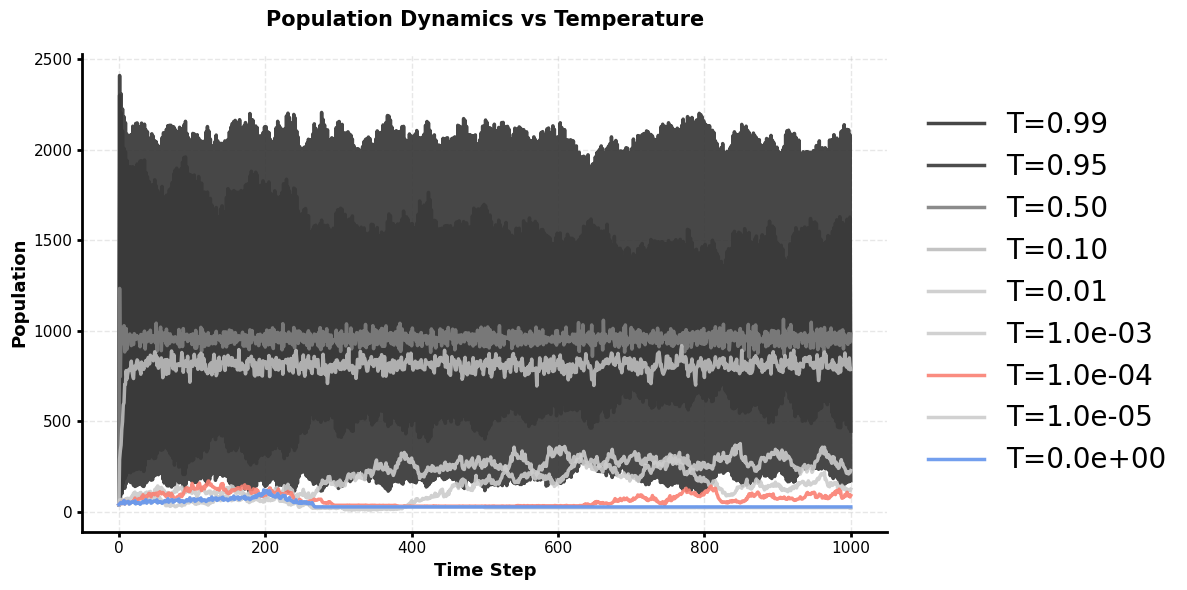

Plotted in this order:
1. T=0.99 (key=0.99)
2. T=0.95 (key=0.95)
3. T=0.50 (key=0.5)
4. T=0.10 (key=0.1)
5. T=0.01 (key=0.01)
6. T=1.0e-03 (key=0.001)
7. T=1.0e-04 (key=0.0001)
8. T=1.0e-05 (key=1e-05)
9. T=0.0e+00 (key=0.0)


In [272]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 6))

# Convert string keys to floats and reverse
keys = [float(k) for k in cnt_pop_dict.keys()]
keys = sorted(keys, reverse=True)

# Get non-special temperatures for normalization
special_temps = {0.0, 0.0001, 1e-4, 1e-05}
regular_temps = [k for k in keys if k not in special_temps]

if regular_temps:
    min_temp = min(regular_temps)
    max_temp = max(regular_temps)
    temp_range = max_temp - min_temp if max_temp > min_temp else 1
else:
    min_temp, max_temp, temp_range = 0, 1, 1

# Plot and collect legend info
legend_handles = []
legend_labels = []

for key in keys:
    # Determine color
    if abs(key - 0.0) < 1e-9:  # T=0 (deterministic)
        color = 'cornflowerblue'
    elif abs(key - 1e-4) < 1e-9:  # T=1E-3
        color = 'salmon'
    else:
        # Grayscale: higher temp = darker
        normalized = (key - min_temp) / temp_range
        gray_value = 0.8 - (0.6 * normalized)
        color = (gray_value, gray_value, gray_value)
    
    # Handle dict key lookup
    if str(key) in cnt_pop_dict:
        data = cnt_pop_dict[str(key)]
    elif f'{key:.0e}' in cnt_pop_dict:
        data = cnt_pop_dict[f'{key:.0e}']
    elif str(float(key)) in cnt_pop_dict:
        data = cnt_pop_dict[str(float(key))]
    else:
        # Try to find matching key
        for dict_key in cnt_pop_dict.keys():
            if abs(float(dict_key) - key) < 1e-10:
                data = cnt_pop_dict[dict_key]
                break
    
    # Format label
    if key < 0.01:
        label = f'T={key:.1e}'
    else:
        label = f'T={key:.2f}'
    
    # Plot WITHOUT label (we'll create custom legend)
    line = ax.plot(data, 
                   linewidth=2.5, 
                   alpha=0.9,
                   color=color)[0]
    
    # Store for legend
    legend_handles.append(line)
    legend_labels.append(label)

# Labels and styling
ax.set_xlabel('Time Step', fontsize=13, fontweight='bold')
ax.set_ylabel('Population', fontsize=13, fontweight='bold')
ax.set_title('Population Dynamics vs Temperature', 
            fontsize=15, fontweight='bold', pad=20)

# Clean axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(width=2, labelsize=11)

# Custom legend with explicit handles and labels
ax.legend(handles=legend_handles,
         labels=legend_labels,
         loc='center left', 
         bbox_to_anchor=(1.02, 0.5),
         frameon=False,
         fontsize=20)

ax.grid(True, alpha=0.3, linewidth=1, linestyle='--')

plt.tight_layout()
plt.savefig('./outputs/V20251112_gosper_glider_gun_population_dynamics.png', dpi=600, bbox_inches='tight')
plt.show()

# Debug: Print what we plotted
print("Plotted in this order:")
for i, (label, key) in enumerate(zip(legend_labels, keys)):
    print(f"{i+1}. {label} (key={key})")

In [230]:
cnt_pop_dict.keys()

dict_keys(['0.0', '1e-05', '0.0001', '0.001', '0.01', '0.1', '0.5', '0.95', '0.99'])